## **Importing algorithms**


In [1]:
import sys
from pathlib import Path
import time

sys.path.append(str(Path("/Users/nada/PycharmProjects/Mars_rover_path_finding /Mars_rover_path_finding/src").resolve()))

In [2]:
from algorithms.bfs import bfs
from algorithms.dfs import dfs
from algorithms.ucs import ucs
from algorithms.ids import ids
from algorithms.A_star import A_star
from algorithms.hill_climbing import hill_climbing

## **Initializing the Maps (Elevation and Terrain)**

In [3]:
import numpy as np
np.random.seed(42)

# Simulated grid dimensions
N, M = 50, 50
cliff_prob = 0.1

elevation = np.random.randint(0, 30, size=(N, M))
terrain = np.random.choice([0, 1, 2, 3], size=(N, M), p=[0.5, 0.25, 0.15, cliff_prob])

# To make sure start and goal are valid
start = (0, 0)
goal = (N-1, M-1)
terrain[start] = 0
terrain[goal] = 0

terrain_cost = {0: 4, 1: 8, 2: 13, 3: np.inf}

In [4]:
def move_cost(current, neighbor):
    x1, y1 = current
    x2, y2 = neighbor

    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)

    slope = abs(elevation[x2, y2] - elevation[x1, y1])

    t_factor = terrain_cost[terrain[x2, y2]]

    if t_factor == np.inf:
        return np.inf
    return distance * t_factor * (1 + slope)

print("Cost from start to (0,1):", move_cost(start, (0,1)))

print("Elevation Map:\n", elevation)
print("Terrain Map:\n", terrain)

Cost from start to (0,1): inf
Elevation Map:
 [[ 6 19 28 ... 14 29 18]
 [11 22 19 ... 25 11  1]
 [ 9 29  3 ...  4  9  6]
 ...
 [14 24 29 ... 11 24 13]
 [14 15 21 ...  8 17 11]
 [ 7  7 17 ...  5 17 18]]
Terrain Map:
 [[0 3 3 ... 1 0 0]
 [3 0 1 ... 2 0 1]
 [0 1 0 ... 0 2 0]
 ...
 [2 0 1 ... 1 0 3]
 [0 1 0 ... 2 0 0]
 [0 2 2 ... 0 0 0]]


In [5]:
def path_cost(path):
    total = 0
    for i in range(len(path)-1):
        total += move_cost(path[i], path[i+1])
    return total

In [7]:
import networkx as nx
G = nx.DiGraph()

directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]

for x in range(N):
    for y in range(M):
        if terrain_cost[terrain[x,y]] == np.inf:
            continue
        for dx, dy in directions:
            nx_, ny_ = x + dx, y + dy
            if 0 <= nx_ < N and 0 <= ny_ < M:
                cost = move_cost((x,y), (nx_,ny_))
                if cost < np.inf:
                    G.add_edge((x,y), (nx_,ny_), weight=cost)


print(G[(0,0)])

{(1, 1): {'weight': 96.16652224137047}}


## **High-Fidelity Realistic Visualization**

In [8]:
import matplotlib as mpl
mpl.rcParams['animation.writer'] = 'ffmpeg'
# You can keep the bitrate setting you already added
mpl.rcParams['animation.bitrate'] = 1200

In [9]:
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import animation
from IPython.display import HTML

# Make inline animation embeds smaller/allowed
mpl.rcParams['animation.embed_limit'] = 100  # MB
mpl.rcParams['animation.bitrate'] = 1200     # lower bitrate → smaller video


def visualize_realistic_mission(elevation_map, terrain_map, path_coords):
    # 1. Smooth the Elevation Map for a "Real" Look
    # This turns sharp random spikes into rolling hills
    Z_smooth = gaussian_filter(elevation_map.astype(float), sigma=1.2)

    # 2. Interpolate Path for Smooth Continuous Movement
    # We generate intermediate steps between each grid point
    steps_per_move = 2  # fewer interpolated steps → fewer frames
    smooth_path_x = []
    smooth_path_y = []
    smooth_path_z = []

    for i in range(len(path_coords) - 1):
        p1 = path_coords[i]
        p2 = path_coords[i + 1]

        # Linearly interpolate X and Y coordinates
        xs = np.linspace(p1[1], p2[1], steps_per_move, endpoint=False)
        ys = np.linspace(p1[0], p2[0], steps_per_move, endpoint=False)

        # Get smoothed Z elevation for these points
        # Simple approximation: interp between the Z of the two nodes
        z1 = Z_smooth[p1[0], p1[1]]
        z2 = Z_smooth[p2[0], p2[1]]
        zs = np.linspace(z1, z2, steps_per_move, endpoint=False)

        smooth_path_x.extend(xs)
        smooth_path_y.extend(ys)
        smooth_path_z.extend(zs)

    # Append the final destination
    last = path_coords[-1]
    smooth_path_x.append(last[1])
    smooth_path_y.append(last[0])
    smooth_path_z.append(Z_smooth[last[0], last[1]])

    # 3. Setup the Scene
    # "More spread" -> significantly wider figure, but keep pixels reasonable
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax = fig.add_subplot(111, projection='3d')

    rows, cols = elevation_map.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

    # 4. Realistic Coloring
    # 0: Sand (PaleGoldenrod), 1: Rough (SandyBrown), 2: Rocky (SaddleBrown), 3: Cliff (DarkSlateGrey)
    real_colors = ['#EEE8AA', '#F4A460', '#8B4513', '#2F4F4F']
    cmap = colors.ListedColormap(real_colors)
    norm = colors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

    # Map terrain categories to colors
    face_colors = cmap(norm(terrain_map))

    # Plot Surface using the SMOOTHED elevation
    ax.plot_surface(X, Y, Z_smooth, facecolors=face_colors,
                    rstride=2, cstride=2, shade=True, alpha=0.9,
                    linewidth=0, antialiased=False)

    # Plot the faint trail of the planned path on the ground
    path_x_grid = [p[1] for p in path_coords]
    path_y_grid = [p[0] for p in path_coords]
    path_z_grid = [Z_smooth[p[0], p[1]] + 0.1 for p in path_coords]
    ax.plot(path_x_grid, path_y_grid, path_z_grid, color='white', linestyle=':', linewidth=1, alpha=0.5,
            label='Planned Route')

    # Create the Rover with high-visibility styling (bright red + halo)
    # Halo (slightly larger, semi-transparent white)
    halo, = ax.plot([], [], [], marker='o', markersize=24,
                    color='white', alpha=0.6, markeredgecolor='none',
                    zorder=2)
    # Foreground rover dot (bright red with bold black edge)
    rover, = ax.plot([], [], [], marker='o', markersize=18, color='#ff1744',
                     markeredgecolor='black', markeredgewidth=3, label='Rover',
                     zorder=3)

    # 5. Styling and View
    ax.set_title('High-Fidelity Mars Mission Simulation', fontsize=16, color='black')
    ax.set_axis_off()  # Hide axes for a more "cinematic" view

    # Adjust view to look "spread" out
    ax.view_init(elev=55, azim=-60)

    # Scale Z axis to not look too flat or too spiky
    ax.set_zlim(0, 15)

    def update(frame):
        cx = smooth_path_x[frame]
        cy = smooth_path_y[frame]
        cz = smooth_path_z[frame] + 0.6  # Lift rover slightly above terrain

        # Update halo first (underlay)
        halo.set_data([cx], [cy])
        halo.set_3d_properties([cz])
        # Update rover (overlay)
        rover.set_data([cx], [cy])
        rover.set_3d_properties([cz])
        return halo, rover

    # Animate
    # Ensure we actually render frames; avoid downsampling to prevent 0-duration
    frames = range(0, len(smooth_path_x))
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=False)

    # Do not close the figure here; some writers need it alive during save
    return anim

## **BFS**

In [13]:
start_t = time.perf_counter()
bfs_path = bfs(G, start, goal)
bfs_elapsed = time.perf_counter() - start_t
print(f"BFS: time={bfs_elapsed:.6f}s, path_len={len(bfs_path) if bfs_path else None}")

BFS: time=0.011189s, path_len=52


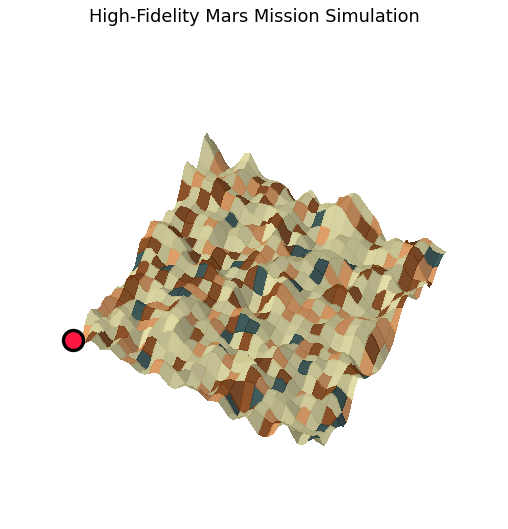

In [10]:
anim_real = visualize_realistic_mission(elevation, terrain, bfs_path)
anim_real.save('bfs_rover.mp4', writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video('bfs_rover.mp4', embed=False)  # small notebook; external file playback

## **DFS**

In [11]:
start_t = time.perf_counter()
dfs_path, dfs_depth = dfs(G, start, goal)
dfs_elapsed = time.perf_counter() - start_t
print(f"DFS: depth={dfs_depth}, time={dfs_elapsed:.6f}s, path_len={len(dfs_path) if dfs_path else None}")

DFS: depth=376, time=0.006103s, path_len=377


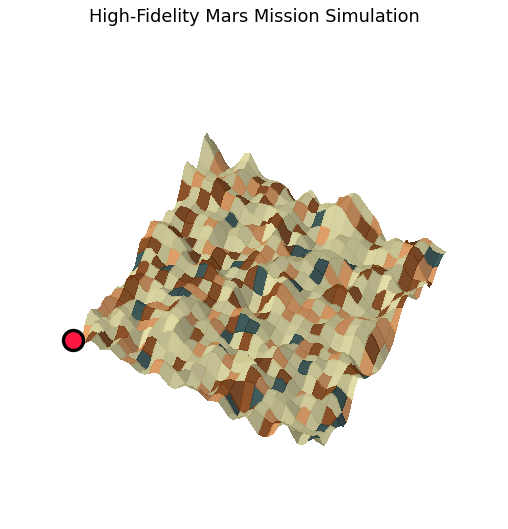

In [12]:
anim_real = visualize_realistic_mission(elevation, terrain, dfs_path)
anim_real.save('dfs_rover.mp4', writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video('dfs_rover.mp4', embed=False)

## **IDS**

In [15]:
max_depth = 100
start_t = time.perf_counter()
ids_path, ids_depth = ids(G, start, goal, max_depth)
ids_elapsed = time.perf_counter() - start_t
print(f"IDS: depth={ids_depth}, time={ids_elapsed:.6f} s, path_len={len(ids_path) if ids_path else None}")

IDS: depth=51, time=1.234975 s, path_len=52


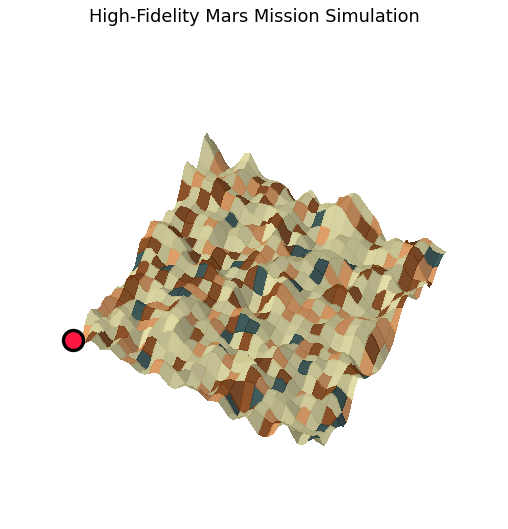

In [16]:
anim_real = visualize_realistic_mission(elevation, terrain, ids_path)
anim_real.save(f"ids_path_max_{max_depth}_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"ids_path_max_{max_depth}_rover.mp4", embed=False)

## **DFS vs IDS depth, time, path length**

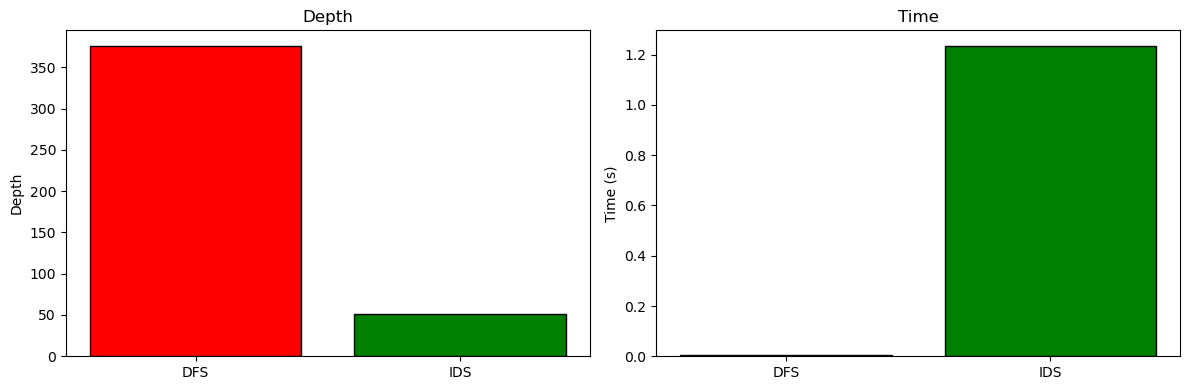

In [22]:
import matplotlib.pyplot as plt

depth_vals = [dfs_depth, ids_depth]
time_vals = [dfs_elapsed, ids_elapsed]
path_vals = [len(dfs_path), len(ids_path)]

labels = ['DFS', 'IDS']
bar_colors = ['red', 'green']

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(labels, depth_vals, color=bar_colors, edgecolor='black')
axs[0].set_title('Depth')
axs[0].set_ylabel('Depth')

axs[1].bar(labels, time_vals, color=bar_colors, edgecolor='black')
axs[1].set_title('Time')
axs[1].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()


## **UCS**

In [10]:
start_t = time.perf_counter()
ucs_path, ucs_cost = ucs(G, start, goal)
ucs_elapsed = time.perf_counter() - start_t
print(f"UCS: cost={ucs_cost}, time={ucs_elapsed:.6f} s, path_len={len(ucs_path) if ucs_path else None}")

UCS: cost=1945.329219338134, time=0.025447 s, path_len=78


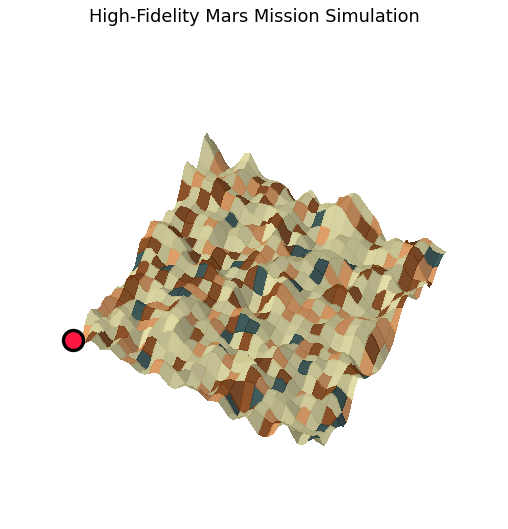

In [12]:
anim_real = visualize_realistic_mission(elevation, terrain, ucs_path)
anim_real.save(f"ucs_rover.mp4", writer='ffmpeg', fps=20, dpi=100, bitrate=1200)
from IPython.display import Video
Video(f"ucs_rover.mp4", embed=False)

## **A_star**

In [11]:
start_t = time.perf_counter()
Astar_path, Astar_cost = A_star(G, start, goal, terrain, elevation, terrain_cost)
Astar_elapsed = time.perf_counter() - start_t
print(f"Astar: cost={Astar_cost}, time={Astar_elapsed:.6f} s, path_len={len(Astar_path) if Astar_path else None}")

Astar: cost=1945.329219338134, time=0.042317 s, path_len=78
